### TASK_01
#### Coding Assignment Task # 1
- Dataset: IEDGAR SEC filings (public data) -
- https://huggingface.co/datasets/eloukas/edgar-corpus
- Language: Python
- Implementation: Pyspark
- Submission: Github repository containing code + plots (jpeg).
- Expected Maximum Duration: 3 hours

Given a set of documents: create a solution that allows the end user to understand the documents in a two dimensional space and to identify outliers.
* Dataset:
- Year: 2020
- Filing type: 10K
- Sections: All
- Companies: Limit to 10.

* Steps:
1. Convert the documents to chunks,
2. Convert the chunks into embeddings,
3. Standard scale the embeddings,
4. Perform principal components analysis,
5. Apply dimensionality reduction,
6. Perform Kmeans clustering and assign chunks an cluster number.
7. Create an outlier flag.
8. Plot(s)
- Embeddings in 2 dimensions
- Colored by assigned clusters.
- Colored by outlier flag
- Colored by section number.

#### Dataset card:
This dataset card is based on the paper EDGAR-CORPUS: Billions of Tokens Make The World Go Round authored by Lefteris Loukas et.al, as published in the ECONLP 2021 workshop.
This dataset contains the annual reports of public companies from 1993-2020 from SEC EDGAR filings.
There is supported functionality to load a specific year.
Care: since this is a corpus dataset, different train/val/test splits do not have any special meaning. It's the default HF card format to have train/val/test splits.
If you wish to load specific year(s) of specific companies, you probably want to use the open-source software which generated this dataset, EDGAR-CRAWLER: https://github.com/nlpaueb/edgar-crawler.

In [213]:
# import os
import regex as re
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import colorcet as cc
from scipy.spatial.distance import cdist

import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition  import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score


import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, length, concat_ws, udf, explode, pandas_udf, lit, count, avg, max as spark_max, min as spark_min, length
from pyspark.sql.types import ArrayType, StringType, FloatType


from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

import torch
print(torch.cuda.is_available())





# Load environnt variables from .env file
# from dotenv import load_dotenv
# load_dotenv()
# os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
import os
os.environ['JAVA_HOME'] = r'D:\Softwares\Microsoft\jdk-17.0.15.6-hotspot'

# import sys


# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))


True


In [2]:
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
print(sys.executable)

D:\Softwares\Anaconda3\envs\pytorchGPU\python.exe


In [4]:
# Load a specific year and split
edgar_corpus_2020_raw = datasets.load_dataset("eloukas/edgar-corpus", "year_2020")

D:\Softwares\Anaconda3\envs\pytorchGPU\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for eloukas/edgar-corpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eloukas/edgar-corpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
edgar_corpus_2020_raw

DatasetDict({
    train: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15'],
        num_rows: 5480
    })
    validation: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15'],
        num_rows: 686
    })
    test: Dataset({
        features: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'sect

In [6]:
# Start Spark session
spark = SparkSession.builder \
    .appName("AIG_SEC_Filing_Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.python.worker.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .config("spark.sql.execution.pyspark.udf.faulthandler.enabled","true") \
    .config("spark.python.worker.faulthandler.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")



# Exploratory data analysis

## Sanity Checks

In [ ]:
edgar_corpus_2020_raw["train"].to_parquet("D:\\PracticeProjects\\TASK_01\\Data\\df.parquet")
df_train = spark.read.parquet("D:\\PracticeProjects\\TASK_01\\Data\\df.parquet")
print(f"No of rows: {df_train.count()} and no. of columns: {len(df_train.columns)} in Train split")

In [ ]:
edgar_corpus_2020_raw["validation"].to_parquet("D:\\PracticeProjects\\TASK_01\\Data\\df_val.parquet")
df_val = spark.read.parquet("D:\\PracticeProjects\\TASK_01\\Data\\df_val.parquet")
print(f"No of rows: {df_val.count()} and no. of columns: {len(df_val.columns)} in Validation split")

In [ ]:
edgar_corpus_2020_raw["test"].to_parquet("D:\\PracticeProjects\\TASK_01\\Data\\df_test.parquet")
df_test = spark.read.parquet("D:\\PracticeProjects\\TASK_01\\Data\\df_test.parquet")
print(f"No of rows: {df_test.count()} and no. of columns: {len(df_test.columns)} in Test split")

* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split

In [ ]:
df_train.columns == df_val.columns == df_test.columns

* All the splits have same columns

In [ ]:
columns = df_train.columns
null_columns ={column:df_train.filter(col(column).isNull()).count() for column in columns}
print(null_columns)
    

In [ ]:
columns = df_val.columns
null_columns ={column:df_val.filter(col(column).isNull()).count() for column in columns}
print(null_columns)

In [ ]:
columns = df_test.columns
null_columns ={column:df_val.filter(col(column).isNull()).count() for column in columns}
print(null_columns)

* None of columns have any null or missing values in Train, Val and Test

In [ ]:
### Below is the metadata definition from source repo - 
# https://github.com/lefterisloukas/edgar-crawler/blob/main/README.md

# {
#   "cik": "320193",
#   "company": "Apple Inc.",
#   "filing_type": "10-K",
#   "filing_date": "2022-10-28",
#   "period_of_report": "2022-09-24",
#   "sic": "3571",
#   "state_of_inc": "CA",
#   "state_location": "CA",
#   "fiscal_year_end": "0924",
#   "filing_html_index": "https://www.sec.gov/Archives/edgar/data/320193/0000320193-22-000108-index.html",
#   "htm_filing_link": "https://www.sec.gov/Archives/edgar/data/320193/000032019322000108/aapl-20220924.htm",
#   "complete_text_filing_link": "https://www.sec.gov/Archives/edgar/data/320193/0000320193-22-000108.txt",
#   "filename": "320193_10K_2022_0000320193-22-000108.htm",
#   "item_1": "Item 1. Business\nCompany Background\nThe Company designs, manufactures ...",
#   "item_1A": "Item 1A. Risk Factors\nThe Company’s business, reputation, results of ...",
#   "item_1B": "Item 1B. Unresolved Staff Comments\nNone.",
#   "item_1C": "",
#   "item_2": "Item 2. Properties\nThe Company’s headquarters are located in Cupertino, California. ...",
#   "item_3": "Item 3. Legal Proceedings\nEpic Games\nEpic Games, Inc. (“Epic”) filed a lawsuit ...",
#   "item_4": "Item 4. Mine Safety Disclosures\nNot applicable. ...",
#   "item_5": "Item 5. Market for Registrant’s Common Equity, Related Stockholder ...",
#   "item_6": "Item 6. [Reserved]\nApple Inc. | 2022 Form 10-K | 19",
#   "item_7": "Item 7. Management’s Discussion and Analysis of Financial Condition ...",
#   "item_8": "Item 8. Financial Statements and Supplementary Data\nAll financial ...",
#   "item_9": "Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone.",
#   "item_9A": "Item 9A. Controls and Procedures\nEvaluation of Disclosure Controls and ...",
#   "item_9B": "Item 9B. Other Information\nRule 10b5-1 Trading Plans\nDuring the three months ...",
#   "item_9C": "Item 9C. Disclosure Regarding Foreign Jurisdictions that Prevent Inspections\nNot applicable. ...",
#   "item_10": "Item 10. Directors, Executive Officers and Corporate Governance\nThe information required ...",
#   "item_11": "Item 11. Executive Compensation\nThe information required by this Item will be included ...",
#   "item_12": "Item 12. Security Ownership of Certain Beneficial Owners and Management and ...",
#   "item_13": "Item 13. Certain Relationships and Related Transactions, and Director Independence ...",
#   "item_14": "Item 14. Principal Accountant Fees and Services\nThe information required ...",
#   "item_15": "Item 15. Exhibit and Financial Statement Schedules\n(a)Documents filed as part ...",
#   "item_16": "Item 16. Form 10-K Summary\nNone.\nApple Inc. | 2022 Form 10-K | 57"
# }

In [ ]:
print(df_train.first().asDict())

In [ ]:
# Count the number of ciks in the train data
cik_count = df_train.groupby("cik").count()
cik_count.filter("count>1").show()


In [ ]:
# Count the number of ciks in the train data
cik_count = df_val.groupby("cik").count()
cik_count.filter("count>1").show()

In [ ]:
# Count the number of ciks in the train data
cik_count = df_test.groupby("cik").count()
cik_count.filter("count>1").show()

* Each split has only a single entry for every unique cik

In [ ]:
df_train_all_companies = df_train.select("*")
df_train = df_train_all_companies.limit(10)

The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies

In [ ]:
cik_list_train = [row["cik"] for row in df_train.select("cik").distinct().collect()]
cik_list_val = [row["cik"] for row in df_val.select("cik").distinct().collect()]
cik_list_test = [row["cik"] for row in df_test.select("cik").distinct().collect()]
print(set(cik_list_train) & set(cik_list_val) & set(cik_list_test))


* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.

In [ ]:
print([row["year"] for row in df_train.select("year").distinct().collect()])

* All the filings selected in df_train are from the year 2020

In [ ]:
df_train.describe()

In [ ]:
df_train.printSchema()

All data types are strings, which is expected

* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split
* All the splits have same columns
* None of columns have any null or missing values in Train, Val and Test
* Each split has only a single entry for every unique cik
* The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies
* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.
* All the filings selected in df_train are from the year 2020
* All data types are strings, which is expected

### Univariate Analysis

In [ ]:
df_train.summary().show()

In [ ]:
column_stats = df_train.select([length(col(c)) for c in df_train.columns if c not in ["filename", "cik", "year"]])

In [ ]:
column_stats.summary().show()

* section_1: Min: 10543, max: 68190
* section_1A: min: 201, max: 313147
* section_1B: min: 48, max: 146
* section_2: min: 163, max: 2159
* section_3: min: 169, max: 11676
* section_4: min:62, max: 959
* section_5: min: 1133, max: 12065
* section_6: min: 53, max: 1569
* section_7: min:384,mean: 47K, max: 95590
* section_8: min: 177, mean: 78K, max: 151611
* section_9: min: 0, max: 108
* section_9A: min: 2104, max: 8758
* section_9B: min 50, max: 1215,
* section_10: min: 273, max: 22387
* section_11: min 136, max 16404
* section_12: min: 208, max: 4485
* section_13: min 187 max:12936
* section_14: min_160, max: 1908
* section_15: min: 1049, mean: 27060, max: 204374

* data shows huge variance in each section with sec 1A having the highest variation
* section 9 might have empty fields, some companies do not file section 9A
* Variation of data size needs to be accounted for in processing
* Large sections such as section_1, section_1A, section_7, section_8and section_15 will have a lot of chunks
* Chunking each section differently might help

In [ ]:
df_train.select("section_1B").show(truncate = False)

* section_1B mostly has boiler plate information for these 10 companies as most of them provided "unresolved staff comments". Potential candidate to ignore

In [ ]:
df_train.select("section_1A").filter(length(df_train["section_1A"])<15000).show(truncate = False)

* section_1A: Also has lesser records for comanies that classifies as "small reporting companies". There is a chance that for these companies section_1A can be excluded. Smaller records will mist likely have boilerplate statements like section 1B and can be ignored.
* section_1A: For the selcted 10 companies, section_1A only has data below 15,000 characters for only 1 company. This can be considerd an outlier

In [ ]:
df_train.select("section_2").filter(length(df_train["section_2"])<200).show(truncate = False)

In [ ]:
df_train.select("section_3").filter(length(df_train["section_3"])<200).show(truncate = False)

In [ ]:
df_train.select("section_4").filter(length(df_train["section_4"])<500).show(truncate = False)

In [ ]:
df_train.select("section_4").filter(length(df_train["section_4"])>500).show(truncate = False)

* section_4 mostly has boiler plate information for 9 companies as most of them provided "Not Applicable". Potential candidate to ignore. Only 1 company out of 10 has useful data. Sections with less than 500 characters can be ignored

In [ ]:
df_train.select("section_6").filter(length(df_train["section_6"])<200).show(truncate = False)

* section_6 also has a clause of not being applied to "smaller reporting companies"

In [ ]:
df_train.select("section_7A").filter(length(df_train["section_7A"])<200).show(truncate = False)

* section_7 also has a clause of not being applied to "smaller reporting companies"

In [ ]:
df_train.select("section_9").filter(length(df_train["section_9"])<200).show(truncate = False)

* 9 out of 10 companies have boilerplate information about section_9: Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone\nItem 9A. This field can also be ignored.

In [ ]:
df_train.select("section_9B").filter(length(df_train["section_9B"])<200).show(truncate = False)

* 8 out of 10 companies have boilerplate information about section_9B:Item 9B. Other Information\nNone\nPART III.\nItem 10.  

In [ ]:
df_train.select("section_10").filter(length(df_train["section_10"])<500).show(truncate = False)

In [ ]:
df_train.select("section_11").filter(length(df_train["section_11"])<500).show(truncate = False)

In [ ]:
df_train.select("section_12").filter(length(df_train["section_12"])<500).show(truncate = False)

In [ ]:
df_train.select("section_13").filter(length(df_train["section_13"])<500).show(truncate = False)

In [ ]:
df_train.select("section_14").filter(length(df_train["section_14"])<500).show(truncate = False)

In [ ]:
df_train.select("section_1A").filter(length(df_train["section_1A"])>5000).take(1)[0][0]


In [ ]:
print(df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0][:6000])

In [ ]:
print(df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0][:6000])

In [ ]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][:5000])

In [ ]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][:2000])

In [ ]:
df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0].find("\n")

In [ ]:
df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0].find("\t")

In [ ]:
df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0].find("\n")

In [ ]:
df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0].find("\t")

In [ ]:
df_train.filter(col("section_1").contains("\n")).count()

In [ ]:
df_train.filter(col("section_1").contains("\n\n")).count()

In [ ]:
df_train.filter(col("section_15").contains("\n")).count()

In [ ]:
df_train.filter(col("section_15").contains("\n\n")).count()

In [ ]:
df_train.filter(col("section_8").contains("\n\n")).count()

* It seems that the field have been extracted out of a continous stream of text with all fields starting with "Item" or "ITEM" section_name and end with "\nNEXT_SECTION_ID" or "\PART ID"
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The longer data within field like section_1 and section_15 - might be sematically separated by \n or newline character but does not contain any '\t' or \n\n. The might also have bullet points in it.

In [ ]:
print(df_train.select("section_15").filter(length(df_train["section_15"])>5000).take(1)[0][0][-100:])

In [ ]:
print(df_train.select("section_1").filter(length(df_train["section_1"])>5000).take(1)[0][0][-100:])

In [ ]:
print(df_train.select("section_8").filter(length(df_train["section_8"])>5000).take(1)[0][0][-200:])

* All the sections end with next item or ITEM number

In [ ]:
[df_train.filter(col(c).rlike(r"[\s]{2,}")).count() for c in df_train.columns]

In [ ]:
[df_train.filter(col(c).contains("�")).count() for c in df_train.columns]

In [ ]:
[df_train.filter(col(c).rlike(r"[\x00-\x1F\x7F-\x9F]")).count() for c in df_train.columns]

* No consecutive spaces to clean
* data contains characters between \x00 - \x1F ASCII (0-31) and ASCII \x7F-\x9F (127-159)

### Conlusions from Data Sanity check:
* No of rows: 5480 and no. of columns: 23 in Train split
* No of rows: 686 and no. of columns: 23 in Validation split
* No of rows: 685 and no. of columns: 23 in Test split
* All the splits have same columns
* None of columns have any null or missing values in Train, Val and Test
* Each split has only a single entry for every unique cik
* The Train/Test/Splits need to be redone conforming with the requirement of using upto 10 companies
* There is no overlap between Train, Test and Val, I will proceed with just Train split going forward and ignore test and val splits.
* All the filings selected in df_train are from the year 2020
* All data types are strings, which is expected

### Conclusions from Univariate analysis:

* section_1B mostly has boiler plate information for these 10 companies as most of them provided "unresolved staff comments". Potential candidate to ignore
* section_1A: Also has lesser records for comanies that classifies as "small reporting companies". There is a chance that for these companies section_1A can be excluded. Smaller records will mist likely have boilerplate statements like section 1B and can be ignored.
* section_1A: For the selcted 10 companies, section_1A only has data below 15,000 characters for only 1 company. This can be considerd an outlier
* section_4 mostly has boiler plate information for 9 companies as most of them provided "Not Applicable". Potential candidate to ignore. Only 1 company out of 10 has useful data. Sections with less than 500 characters can be ignored
* section_6 also has a clause of not being applied to "smaller reporting companies"
* section_7 also has a clause of not being applied to "smaller reporting companies"
* 9 out of 10 companies have boilerplate information about section_9: Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\nNone\nItem 9A. This field can also be ignored.
* It seems that the field have been extracted out of a continous stream of text with all fields starting with "Item" or "ITEM" section_name and end with "\nNEXT_SECTION_ID" or "\PART ID"
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The data is divided into three parts part I, II, III and Part IV should have started after section 15 but it not present in the data
* The longer data within field like section_1 and section_15 - might be sematically separated by \n or newline character but does not contain any '\t' or \n\n. The might also have bullet points in it.
* All the sections end with next item or ITEM number
* Subsections such as "Risk Factors" are beign followed by "\n" or ":"
* Bullet Points are followed by ";"
* No consecutive spaces to clean
* data contains characters between \x00 - \x1F ASCII (0-31) and ASCII \x7F-\x9F (127-159)



## Chunking

### Based on the observations above :
- The text will retain context if split with "\n"
- It might also help to consider ":" as that sometime is identifying the start of a sub-section [ Text between "\n" and ":" will be the header]
- ";" might signal the end of a contextually similar section
- Size of each chunk should be less than 512 tokens or about 2000 characters (to begin with) as I am planning to use BERT based sentence transformers
- An overlap startegy of 200 characters to preserve context

In [7]:
def create_custom_chunks(text:str, overlap: int = 200, chunk_size = 2000)-> list:
    text = re.sub(r'[\x00-\x09\x0B-\x1F\x7F-\x9F]','', text)
    chunks = []

    
    if len(text) <= chunk_size:
        return [text]
        
    prev_chunk_len = 0  
    
    while len(text) > chunk_size:
        right = chunk_size
        
        last_newline_index = text[:chunk_size].rfind("\n")
        
        if last_newline_index > 0:
            right = last_newline_index

        # to ensure chunks have complete words instead of cut words
        # if right > 0 and text[right-1].isalnum() and text[right].isalnum():
        #     last_space = text[:right].rfind(' ')
        #     if last_space > right-50 and last_space > 0:
        #         right = last_space
            
        chunks.append(text[:right].strip())
        
        if prev_chunk_len < 1000 and len(chunks[-1]) < 1000 and len(chunks) > 1:
            chunks[-2]+=" " + chunks[-1]
            chunks = chunks[:-1]
        
        prev_chunk_len = len(chunks[-1])
        
        if right > overlap:
            start = right - overlap
            while start < len(text) and text[start].isalnum() and text[start-1].isalnum():
                start+=1
            text = text[start:]
        else:
            text = text[right:]
    if text:
        chunks.append(text.strip())

    return chunks


In [8]:
df_all_companies = spark.read.parquet("D:\\PracticeProjects\\TASK_01\\Data\\df.parquet")
df = df_all_companies.limit(10)

In [9]:
# chunking_udf = udf(create_custom_chunks, ArrayType(StringType()))    

@pandas_udf(returnType = ArrayType(StringType()))
def chunk_pandas_udf(series):
    return series.apply(create_custom_chunks)



In [10]:
# columns = [column for column in df.columns if column not in ["filename", "cik", "year"]]
# for column in columns:
#     df = df.withColumn(f"{column}"+f"_chunked", chunk_pandas_udf(col(column)))

# for column in columns:
#     df_chunked = df.select("cik", "filename", explode(col(f"{column}_chunked")).alias("chunk")).withColumn("section_name", column))
# # for column in columns:
# #     df = df.withColumn(f"{column}"+f"_chunked", chunking_udf(col(column)))


columns = [column for column in df.columns if column not in ["filename", "cik", "year"]]

# Create chunks
for column in columns:
    df = df.withColumn(f"{column}_chunked", chunk_pandas_udf(col(column)))

# Explode and collect all sections
all_chunks = []
for column in columns:
    df_section = df.select(
        "cik", 
        "filename",
        explode(col(f"{column}_chunked")).alias("chunk")
    ).withColumn("section_name", lit(column))
    
    all_chunks.append(df_section)

# Union all
df_exploded = all_chunks[0]
for chunk_df in all_chunks[1:]:
    df_exploded = df_exploded.union(chunk_df)



In [11]:
print(df_exploded.columns)

['cik', 'filename', 'chunk', 'section_name']


### Sanity checks on chunks

In [12]:
def analyze_max_chunk_length(df):
    chunk_analysis = df.groupBy("cik", "section_name") \
        .agg(
            spark_max(length("chunk")).alias("max_length")
        ).collect()
    
    result = {}
    for row in chunk_analysis:
        if row.cik not in result:
            result[row.cik] = {}
        result[row.cik][row.section_name] = row.max_length

    return result
chunk_length_dict = analyze_max_chunk_length(df_exploded)

In [13]:
# sanity check for chunk sizes
for key, value in chunk_length_dict.items():
    for k, v in value.items():
        print(f"company: {key} : section: {k}: stats: {v}\n")

company: 931059 : section: section_1: stats: 1990

company: 931059 : section: section_1A: stats: 1999

company: 931059 : section: section_1B: stats: 58

company: 931059 : section: section_2: stats: 1777

company: 931059 : section: section_3: stats: 1987

company: 931059 : section: section_4: stats: 63

company: 931059 : section: section_5: stats: 1898

company: 931059 : section: section_6: stats: 56

company: 931059 : section: section_7: stats: 1999

company: 931059 : section: section_7A: stats: 92

company: 931059 : section: section_8: stats: 1999

company: 931059 : section: section_9: stats: 108

company: 931059 : section: section_9A: stats: 1960

company: 931059 : section: section_9B: stats: 50

company: 931059 : section: section_10: stats: 1921

company: 931059 : section: section_11: stats: 1903

company: 931059 : section: section_12: stats: 1798

company: 931059 : section: section_13: stats: 1999

company: 931059 : section: section_14: stats: 1908

company: 931059 : section: secti

In [14]:
df_exploded.printSchema()

root
 |-- cik: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- chunk: string (nullable = true)
 |-- section_name: string (nullable = false)



In [13]:

# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# from collections import defaultdict

# token_results_by_cik = defaultdict(dict)

# rows = df_exploded.select("cik", "chunk", "section_name").collect()


# for row in rows:
#     cik = row["cik"]
#     section = row["section_name"]
#     chunk = row["chunk"]

#     if section not in token_results_by_cik[cik]:
#         token_results_by_cik[cik][section] = {
#             "token_lengths": [],
#         }

#     token_len = len(tokenizer.encode(chunk, truncation=False))
#     token_results_by_cik[cik][section]["token_lengths"].append(token_len)


* Section 15 has a chunk for which the token count is going over 512
* But since it is just by 10 tokens - we can ignore it for now - a trade off to maintain the chunk size of 2000 characters

In [16]:
# Manually check for overlaps
# df_exploded.filter((df_exploded["cik"]=="1356949") & (df_exploded["section_name"] == "section_1")).select("chunk").show(truncate = False)

* Overlap is working fine

### Vectorization

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
# @pandas_udf(ArrayType(FloatType()))
# def generate_embeddings(series: pd.Series) -> pd.Series:
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
    
#     def get_embedding(text):
#         if text:
#             return model.encode(text, show_progress_bar=False).tolist()
#         else:
#             return []
#     return series.apply(get_embedding)

# df_embeddings = df_exploded.select("cik", "filename", "chunk", "section_name").withColumn("embeddings", generate_embeddings(col("chunk")))

In [17]:
# def generate_embeddings_partition(iterator):
#     from sentence_transformers import SentenceTransformer
#     import torch
    
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)
    
#     for row in iterator:
#         text = row['chunk']
#         if text:
#             embedding = model.encode(text).tolist()
#         else:
#             embedding = []
#         yield (*row, embedding)

# # Apply
# df_embeddings = df_exploded.rdd \
#     .mapPartitions(generate_embeddings_partition) \
#     .toDF(["cik", "filename", "chunk", "section_name", "embeddings"])

### Spark failing due to OOM. Moving to Pandas for local processing

In [18]:
df_chunked_pandas = df_exploded.select("cik", "filename", "section_name", "chunk").toPandas()

In [19]:
df_chunked_pandas.describe().T

,count,unique,top,freq
cik,2218,10,1559720,462
filename,2218,10,1559720_2020.htm,462
section_name,2218,20,section_1A,574
chunk,2218,2181,Item 4. Mine Safety Disclosures\nNot applicabl...,5


In [20]:
df_chunked_pandas.shape

(2218, 4)

In [21]:
print(f"No of rows: {df_exploded.count()} and no. of columns: {len(df_exploded.columns)}")

No of rows: 2218 and no. of columns: 4


* Shapes of pandas DF and Pyspark DF match

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

chunks_list = df_chunked_pandas["chunk"].tolist()
embeddings = model.encode(chunks_list, 
                         batch_size=32,
                         show_progress_bar=True,
                         convert_to_tensor=False)
df_chunked_pandas["embeddings"] = embeddings.tolist()
    

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [23]:
df_chunked_pandas.shape

(2218, 5)

In [24]:
df_chunked_pandas

,cik,filename,section_name,chunk,embeddings
0,718413,718413_2020.htm,section_1,Item 1. The Business\nOrganization and Operati...,"[0.0011672422988340259, -0.045266516506671906,..."
1,718413,718413_2020.htm,section_1,currently maintains eleven branch offices in n...,"[0.05401638522744179, -0.024091284722089767, -..."
2,718413,718413_2020.htm,section_1,. The Company also offers business checking an...,"[-0.008359643630683422, -0.06986919790506363, ..."
3,718413,718413_2020.htm,section_1,"the needs of consumers, including personal loa...","[0.07591407746076584, -0.01838328130543232, -0..."
4,718413,718413_2020.htm,section_1,“Management’s Discussion and Analysis of Finan...,"[0.0020793017465621233, -0.08866176754236221, ..."
...,...,...,...,...,...
2213,1356949,1356949_2020.htm,section_15,or officer of Houston Wire & Cable Company (in...,"[-0.10047902911901474, -0.014367612078785896, ..."
2214,1356949,1356949_2020.htm,section_15,of Restricted Stock Unit Award Agreement for K...,"[-0.13158705830574036, -0.019318552687764168, ..."
2215,1356949,1356949_2020.htm,section_15,"and CFO pursuant to 18 U.S.C. Section 1350, as...","[-0.08459225296974182, -0.03362051397562027, -..."
2216,1559720,1559720_2020.htm,section_15,"Item 15. Exhibits, Financial Statement Schedul...","[-0.03925666958093643, 0.0486983060836792, -0...."


* embeddings have been generated and look good

In [25]:
# checking the shape of embeddings:
len(df_chunked_pandas["embeddings"][1])

384

In [26]:
embeddings = np.array(df_chunked_pandas["embeddings"].tolist())
embeddings.shape

(2218, 384)

* embeddings look good

### SCALING

In [27]:
df_chunked_pandas["embeddings_scaled"] = list(StandardScaler().fit_transform(embeddings))

In [28]:
df_chunked_pandas

,cik,filename,section_name,chunk,embeddings,embeddings_scaled
0,718413,718413_2020.htm,section_1,Item 1. The Business\nOrganization and Operati...,"[0.0011672422988340259, -0.045266516506671906,...","[0.8166032409073326, -1.0739629400136539, -0.3..."
1,718413,718413_2020.htm,section_1,currently maintains eleven branch offices in n...,"[0.05401638522744179, -0.024091284722089767, -...","[2.013637050059319, -0.620258278594089, -0.493..."
2,718413,718413_2020.htm,section_1,. The Company also offers business checking an...,"[-0.008359643630683422, -0.06986919790506363, ...","[0.6008191444845762, -1.6011048078064847, -0.4..."
3,718413,718413_2020.htm,section_1,"the needs of consumers, including personal loa...","[0.07591407746076584, -0.01838328130543232, -0...","[2.5096200782250375, -0.497957480006283, -2.02..."
4,718413,718413_2020.htm,section_1,“Management’s Discussion and Analysis of Finan...,"[0.0020793017465621233, -0.08866176754236221, ...","[0.8372613998553756, -2.0037580836351916, -0.8..."
...,...,...,...,...,...,...
2213,1356949,1356949_2020.htm,section_15,or officer of Houston Wire & Cable Company (in...,"[-0.10047902911901474, -0.014367612078785896, ...","[-1.4856861950021538, -0.4119169650601778, 0.6..."
2214,1356949,1356949_2020.htm,section_15,of Restricted Stock Unit Award Agreement for K...,"[-0.13158705830574036, -0.019318552687764168, ...","[-2.1902834809581457, -0.5179967877301891, 0.7..."
2215,1356949,1356949_2020.htm,section_15,"and CFO pursuant to 18 U.S.C. Section 1350, as...","[-0.08459225296974182, -0.03362051397562027, -...","[-1.1258504982379023, -0.8244334099950313, -0...."
2216,1559720,1559720_2020.htm,section_15,"Item 15. Exhibits, Financial Statement Schedul...","[-0.03925666958093643, 0.0486983060836792, -0....","[-0.0989989152834074, 0.9393457430934492, -0.4..."


### PCA

In [29]:
X = np.array(df_chunked_pandas["embeddings_scaled"].tolist())
X.shape

(2218, 384)

In [30]:
pca_results = []
for n_components in range(100,150):
    pca = PCA(n_components = n_components)
    pca.fit(X)
    pca_results.append({"n_components": n_components, 
                        "explained_variance": sum(pca.explained_variance_ratio_ )})
df_pca = pd.DataFrame(pca_results)
df_pca["explained_variance_ratio"] = df_pca["explained_variance"] / df_pca["explained_variance"].sum()


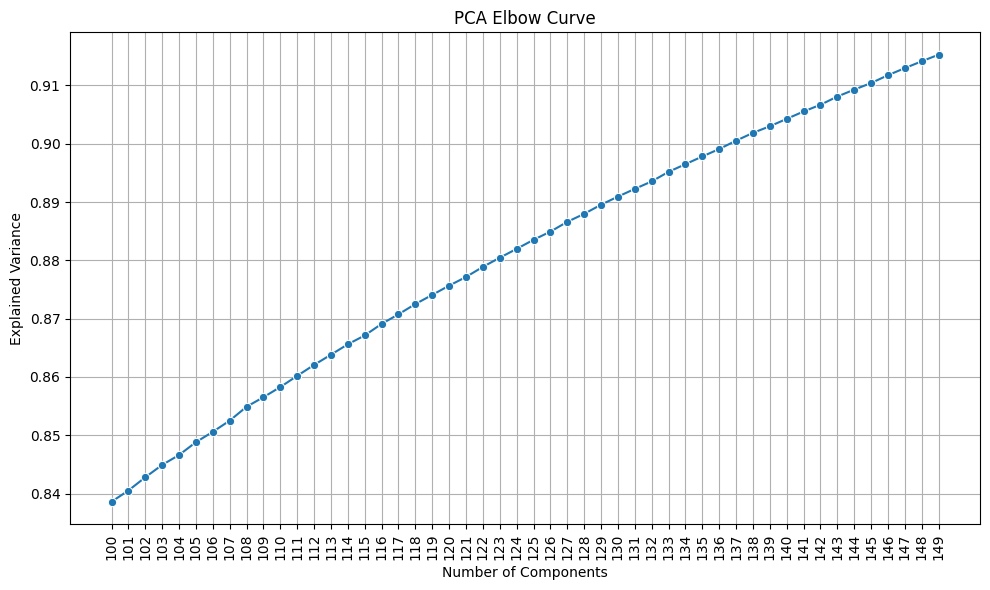

In [31]:
# Plotting Elbow

plt.figure(figsize = (10,6))
sns.lineplot(x="n_components", y="explained_variance", data = df_pca, marker = "o")
plt.title("PCA Elbow Curve")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.xticks(df_pca["n_components"])
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
df_pca[(df_pca["explained_variance"]> 0.85)]

,n_components,explained_variance,explained_variance_ratio
6,106,0.850593,0.019316
7,107,0.852508,0.019359
8,108,0.854893,0.019414
9,109,0.856532,0.019451
10,110,0.858273,0.019490
11,111,0.860193,0.019534
12,112,0.862068,0.019576
13,113,0.863822,0.019616
14,114,0.865608,0.019657
15,115,0.867122,0.019691


In [46]:
# Visualization of PCA results in 2D
pca_2d = PCA(n_components = 2)
pca_2d.fit(X)
X_pca = pca_2d.transform(X)

In [48]:
df_chunked_pandas[['pca_x', 'pca_y']] = pd.DataFrame(X_pca.tolist(), index=df_chunked_pandas.index)

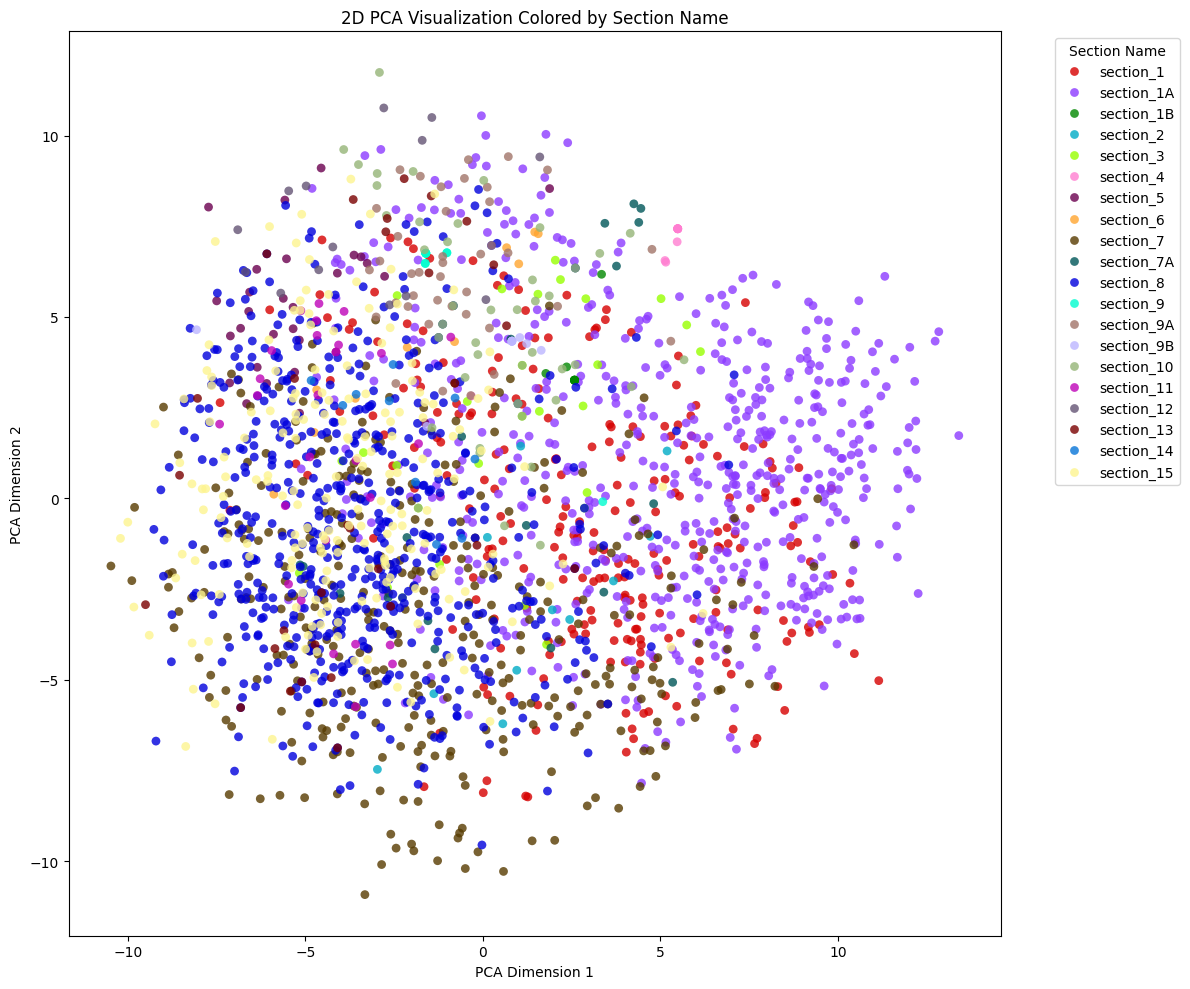

In [49]:
plt.figure(figsize=(12,10))
base_colors = sns.color_palette("tab20", 20)
extra_colors = [(0.8, 0.2, 0.2), (0.2, 0.6, 0.8), (0.5, 0.5, 0.1)]  # Custom RGB tuples
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='pca_x', y='pca_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_chunked_pandas,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D PCA Visualization Colored by Section Name")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(title='Section Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

* Optimal value of principal components is 137 components according to PCA analysis
* Needs 137 + components to explain 90% variance
* Each components adds only 2% variance
* No clear elbow
* Embeddings have information spread across many dimensions
* No dominant principal component

### Dimesnionality Reduction with T-SNE for better visualization

In [33]:
tsne = TSNE(random_state = 42)
X_tsne = tsne.fit_transform(X)
df_chunked_pandas[['tsne_x', 'tsne_y']] = pd.DataFrame(X_tsne.tolist(), index=df_chunked_pandas.index)


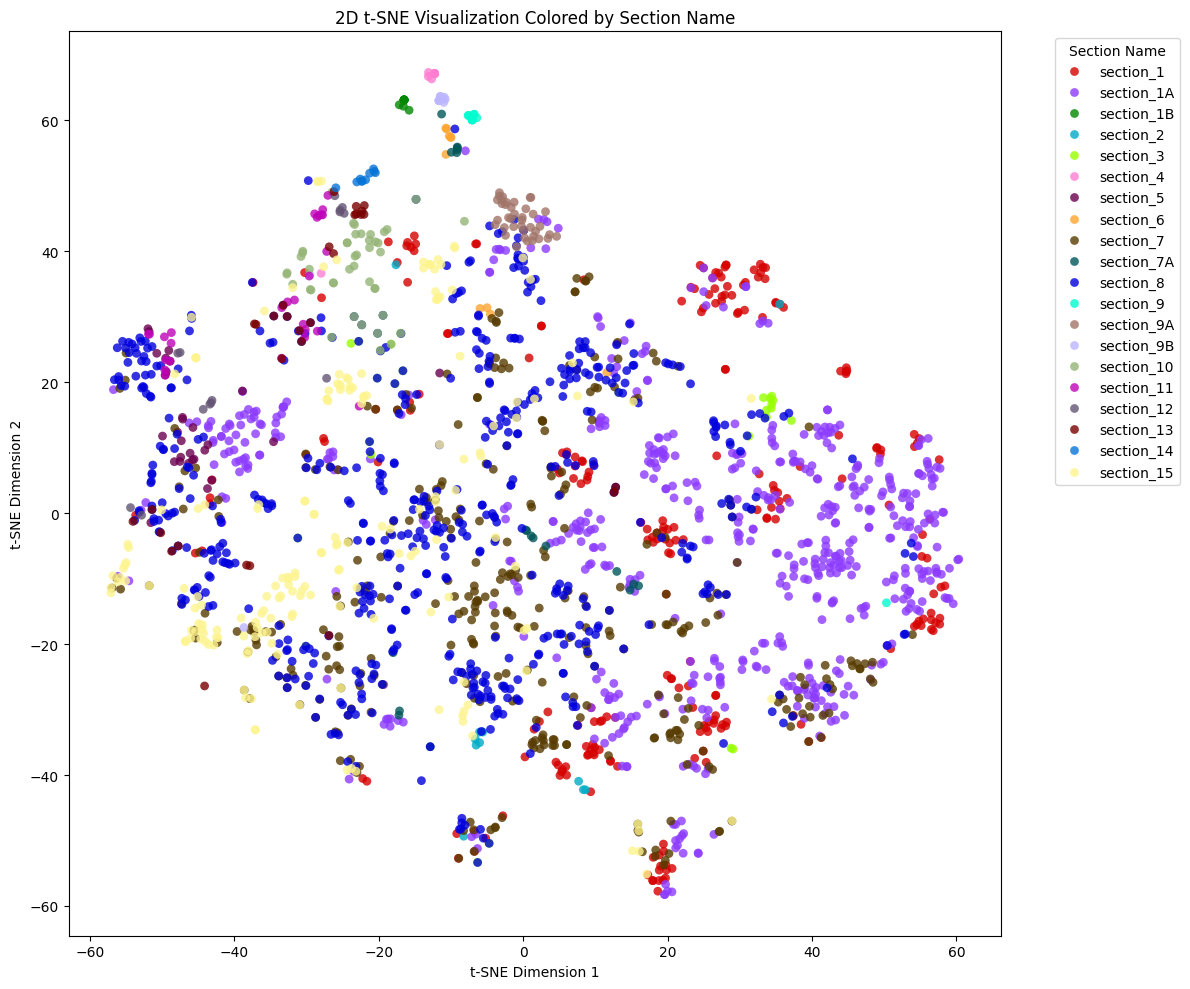

In [45]:
plt.figure(figsize=(12,10))
base_colors = sns.color_palette("tab20", 20)
extra_colors = [(0.8, 0.2, 0.2), (0.2, 0.6, 0.8), (0.5, 0.5, 0.1)]  # Custom RGB tuples
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='tsne_x', y='tsne_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_chunked_pandas,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D t-SNE Visualization Colored by Section Name")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Section Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

* As expected T-SNE visualization shows more distinct clustering than PCA visualization
* There is some clustering by section, but not very tight or completely separated clusters.
* Some sections (e.g., section_1, section_1A, section_7, section_8, section_15) seem to have many points scattered across the plot - diverse topics
* Other sections (e.g., section_9A, section_9B) form smaller, somewhat more distinct groups - standardized vocabulary
* Some overlap between different section clusters is visible, suggesting embeddings from different sections share semantic similarities or are not fully separable in this 2D space - This is because of formal language or legal terminology being used for filings across sections.



### Clustering
#### Data will be reduced in dimensionality to 106 components that explains 85% variations

In [61]:
pca_decomp = PCA(n_components = 106)
pca_decomp.fit(X)
X_pca = pca_decomp.transform(X)

In [63]:
X_pca.shape

(2218, 106)

#### K-Means Clustering

Text(0.5, 1.0, 'Selecting k with Elbow Method')

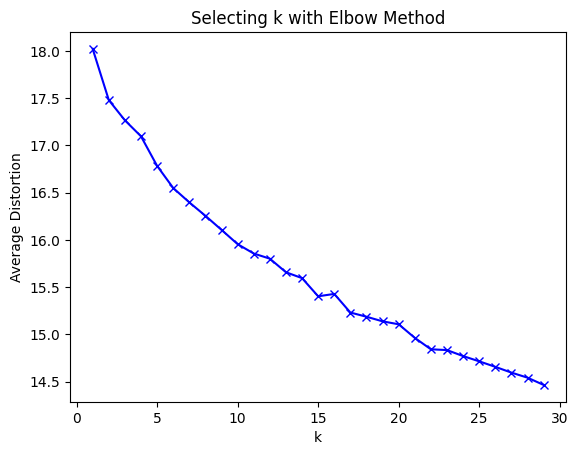

In [76]:
# finding optimal clusters
clusters = range(1,30)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X_pca)
    prediction = model.predict(X_pca)
    meanDistortions.append(sum(np.min(cdist(X_pca, model.cluster_centers_, 'euclidean'), axis = 1))/X_pca.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with Elbow Method')


* There are no clear elbows
* There are a few elbows between 15 and 20 and then between 20 and 25.
* 10 companies with 20 sections each - but sections share terminologies because of boilerplate legal verbiage
* To maintain the trade off between compression and accuracy - we can try 16-20 and between 20-25 as elbows.

For n_clusters = 6, the silhouette score is 0.05550136509643087)
For n_clusters = 7, the silhouette score is 0.055979334690359324)
For n_clusters = 8, the silhouette score is 0.05397204812261632)
For n_clusters = 9, the silhouette score is 0.05711821666551815)
For n_clusters = 10, the silhouette score is 0.05774720194391298)
For n_clusters = 11, the silhouette score is 0.06475802891692414)
For n_clusters = 12, the silhouette score is 0.06738716057153259)
For n_clusters = 13, the silhouette score is 0.07171096413522023)
For n_clusters = 14, the silhouette score is 0.07050524057567421)
For n_clusters = 15, the silhouette score is 0.07003740355297865)
For n_clusters = 16, the silhouette score is 0.07593930124494591)
For n_clusters = 17, the silhouette score is 0.0733178474344561)
For n_clusters = 18, the silhouette score is 0.0758670360582144)
For n_clusters = 19, the silhouette score is 0.07195808609585726)
For n_clusters = 20, the silhouette score is 0.07580523519839819)
For n_clusters 

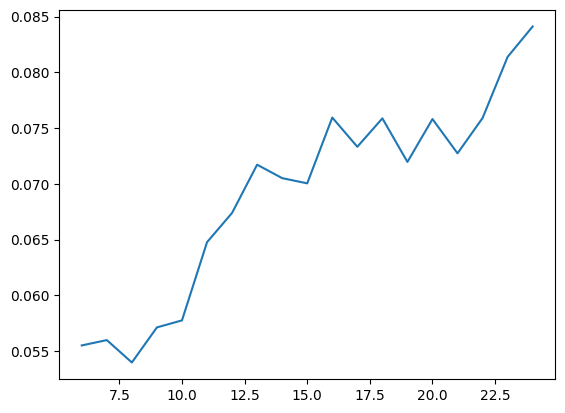

In [198]:
# Calculating Silhouette scores
sil_score = []
cluster_list = list(range(6,25))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((X_pca))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(X_pca, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

* Silhouette Scores are very low shwoing very closely grouped data points or clusters
* 16 clusters seems optimal within the list the perfect tradeoff between compression and accuracy

In [232]:
clusterer = KMeans(16)
preds_16 = clusterer.fit_predict((X_pca))
df_chunked_pandas["K_means_cluster"] = preds_16

cluster_centers = clusterer.cluster_centers_

In [233]:
pd.reset_option('display.max_colwidth')
df_chunked_pandas.head()

,cik,filename,section_name,chunk,embeddings,embeddings_scaled,tsne_x,tsne_y,K_means_cluster
0,718413,718413_2020.htm,section_1,Item 1. The Business\nOrganization and Operati...,"[0.0011672422988340259, -0.045266516506671906,...","[0.8166032409073326, -1.0739629400136539, -0.3...",36.058842,31.440002,6
1,718413,718413_2020.htm,section_1,currently maintains eleven branch offices in n...,"[0.05401638522744179, -0.024091284722089767, -...","[2.013637050059319, -0.620258278594089, -0.493...",34.981136,32.219795,6
2,718413,718413_2020.htm,section_1,. The Company also offers business checking an...,"[-0.008359643630683422, -0.06986919790506363, ...","[0.6008191444845762, -1.6011048078064847, -0.4...",33.504539,35.812752,6
3,718413,718413_2020.htm,section_1,"the needs of consumers, including personal loa...","[0.07591407746076584, -0.01838328130543232, -0...","[2.5096200782250375, -0.497957480006283, -2.02...",30.662157,31.019567,6
4,718413,718413_2020.htm,section_1,“Management’s Discussion and Analysis of Finan...,"[0.0020793017465621233, -0.08866176754236221, ...","[0.8372613998553756, -2.0037580836351916, -0.8...",28.906250,33.287712,6


### Outliers

In [234]:
distances = np.min(cdist(X_pca, clusterer.cluster_centers_, 'euclidean'), axis = 1)
df_chunked_pandas["distance_to_centroid"] = distances

In [235]:
threshold = distances.mean() + 2 * distances.std()
df_chunked_pandas["outliers_kmeans"] = distances > threshold
df_chunked_pandas.head()

,cik,filename,section_name,chunk,embeddings,embeddings_scaled,tsne_x,tsne_y,K_means_cluster,distance_to_centroid,outliers_kmeans
0,718413,718413_2020.htm,section_1,Item 1. The Business\nOrganization and Operati...,"[0.0011672422988340259, -0.045266516506671906,...","[0.8166032409073326, -1.0739629400136539, -0.3...",36.058842,31.440002,6,19.346302,True
1,718413,718413_2020.htm,section_1,currently maintains eleven branch offices in n...,"[0.05401638522744179, -0.024091284722089767, -...","[2.013637050059319, -0.620258278594089, -0.493...",34.981136,32.219795,6,17.708156,False
2,718413,718413_2020.htm,section_1,. The Company also offers business checking an...,"[-0.008359643630683422, -0.06986919790506363, ...","[0.6008191444845762, -1.6011048078064847, -0.4...",33.504539,35.812752,6,16.239533,False
3,718413,718413_2020.htm,section_1,"the needs of consumers, including personal loa...","[0.07591407746076584, -0.01838328130543232, -0...","[2.5096200782250375, -0.497957480006283, -2.02...",30.662157,31.019567,6,16.606712,False
4,718413,718413_2020.htm,section_1,“Management’s Discussion and Analysis of Finan...,"[0.0020793017465621233, -0.08866176754236221, ...","[0.8372613998553756, -2.0037580836351916, -0.8...",28.906250,33.287712,6,15.774717,False


In [254]:
outliers_df = df_chunked_pandas[df_chunked_pandas["outliers_kmeans"]]
outlier_summary = outliers_df.groupby(['cik', 'section_name']).size().reset_index(name='count')
print(f"Total outliers: {len(outliers_df)}")
print("\nOutliers by company and section:")
outlier_summary

Total outliers: 44

Outliers by company and section:


,cik,section_name,count
0,1282224,section_15,1
1,1282224,section_1A,1
2,1282224,section_1B,1
3,1356949,section_1B,1
4,1490873,section_1,6
5,1490873,section_10,1
6,1490873,section_1B,1
7,1490873,section_2,1
8,1490873,section_3,1
9,1490873,section_8,1


In [236]:
pd.set_option('display.max_colwidth', None)
df_chunked_pandas[df_chunked_pandas["K_means_cluster"] == 0]["chunk"].head(1)

35    BSA/AML Requirements. The Company is subject to a number of AML and regulations as a result of being a U.S.-based financial institution. AML requirements are primarily derived from the BSA, as amended by the USA Patriot Act. These laws and regulations are designed to prevent the financial system from being used by criminals to hide illicit proceeds and to impede terrorists’ ability to access and move funds used in support of terrorist activities. Among other things, BSA/AML laws and regulations require financial institutions to establish AML programs that meet certain standards, including, in some instances, expanded reporting, particularly in the area of suspicious transactions, and enhanced information gathering and recordkeeping requirements. The Company maintains an AML program designed to ensure that it is in compliance with all applicable laws, rules and regulations related to AML and anti-terrorist financing initiatives. The AML program provides for a system of internal co

In [237]:
df_chunked_pandas[df_chunked_pandas["K_means_cluster"] == 0]["chunk"].tail(1)

2092    of diluted loss per share because their inclusion is anti-dilutive.\nDOLPHIN ENTERTAINMENT, INC. AND SUBSIDIARIES\nNOTES TO CONSOLIDATED FINANCIAL STATEMENTS\nDECEMBER 31, 2020 AND 2019\nGoing Concern\nIn accordance with ASC Subtopic 205-40, Going Concern, management evaluates whether relevant conditions and events that, when considered in the aggregate, indicate that it is probable the Company will be unable to meet its obligations as they become due within one year after the date that the financial statements are issued. When relevant conditions or events, considered in the aggregate, initially indicate that it is probable that the Company will be unable to meet its obligations as they become due within one year after the date that the financial statements are issued (and therefore they raise substantial doubt about the Company’s ability to continue as a going concern), management evaluates whether its plans that are intended to mitigate those conditions and events, when impl

* Analysis of the above two paragraphs reflect that they both relate to damage, losses and concerns. They do show some semantic closeness to be clustered together.

In [238]:
df_section_clusters = df_chunked_pandas.groupby("section_name")["K_means_cluster"].nunique().reset_index(name="num_clusters")
df_section_clusters


,section_name,num_clusters
0,section_1,14
1,section_10,5
2,section_11,4
3,section_12,3
4,section_13,5
5,section_14,3
6,section_15,13
7,section_1A,16
8,section_1B,1
9,section_2,5


* As interpreted from diagram section_1, section_15, section_1A, section_7 and section_8 are the most diverese and nearly represented in all clusters
* Other except section_3 and section_13 are more or less in smaller number of clusters
* 16 seems to be agood trade-off between accuracy and compression

### Plots

#### Colored by clusters

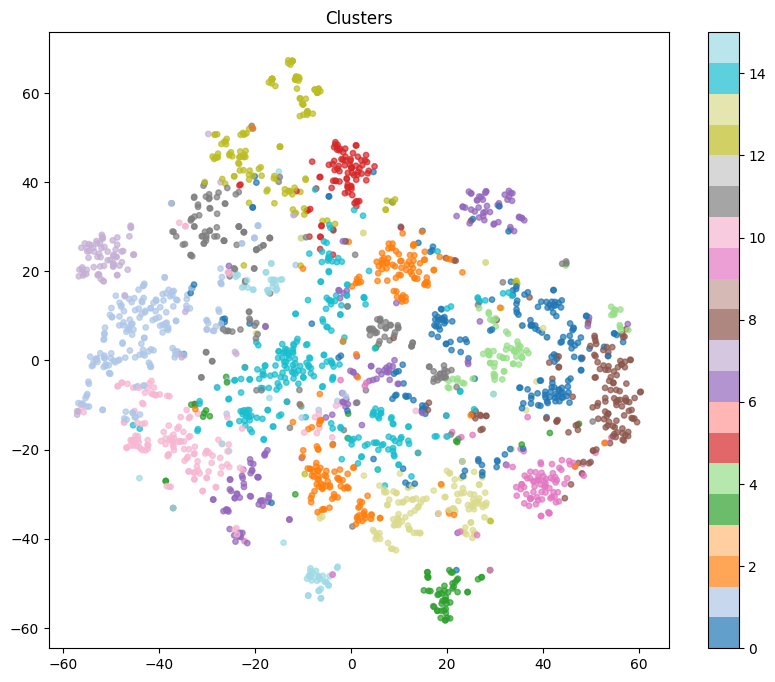

In [247]:
plt.figure(figsize = (10,8))
palette_20 = cc.glasbey[:20]
scatter = plt.scatter(df_chunked_pandas["tsne_x"],
                      df_chunked_pandas["tsne_y"],
                      c = df_chunked_pandas["K_means_cluster"],
                      cmap = "tab20", s = 15, alpha = 0.7)
plt.colorbar(scatter)
plt.title("Clusters")
plt.savefig("clusters.jpeg", dpi=300, bbox_inches='tight')

#### Colored by outliers

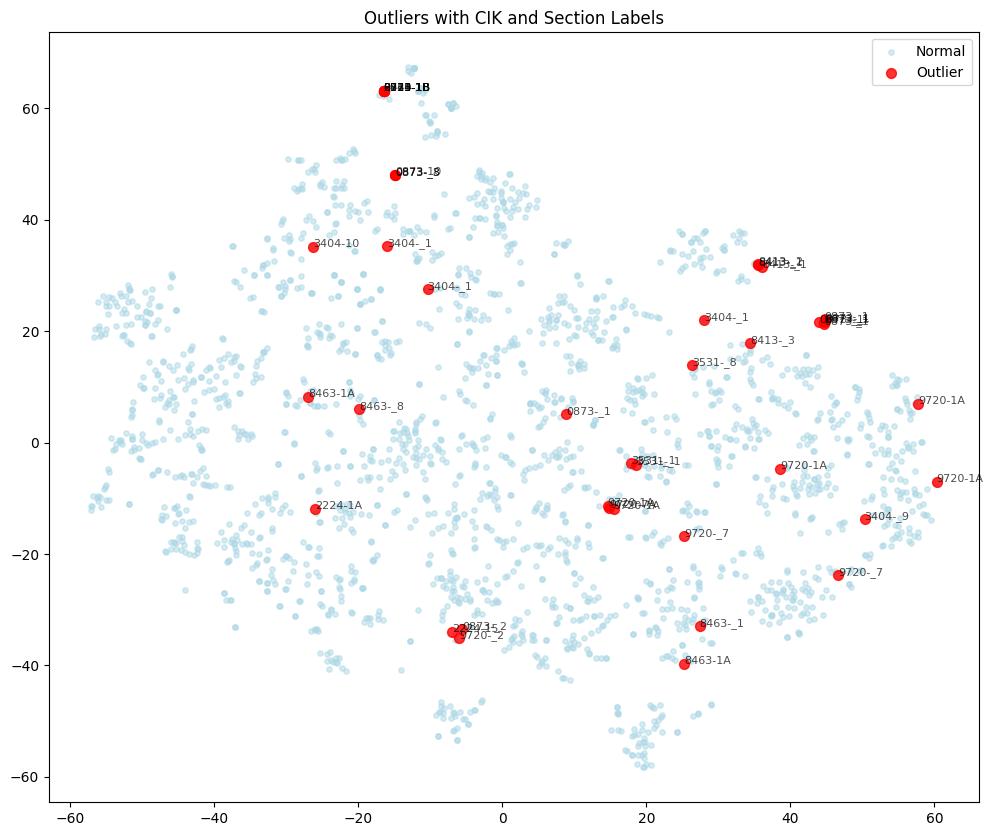

In [257]:
plt.figure(figsize=(12, 10))
# Plot non-outliers
non_outliers = df_chunked_pandas[~df_chunked_pandas["outliers_kmeans"]]
plt.scatter(non_outliers["tsne_x"], non_outliers["tsne_y"], 
           c='lightblue', s=15, alpha=0.5, label='Normal')

# Plot outliers with annotations
outliers = df_chunked_pandas[df_chunked_pandas["outliers_kmeans"]]
plt.scatter(outliers["tsne_x"], outliers["tsne_y"], 
           c='red', s=50, alpha=0.8, label='Outlier')

# Add text labels for outliers
for idx, row in outliers.iterrows():
    plt.annotate(f"{row['cik'][-4:]}-{row['section_name'][-2:]}", 
                (row["tsne_x"], row["tsne_y"]), 
                fontsize=8, alpha=0.7)

plt.legend()
plt.title("Outliers with CIK and Section Labels")
plt.savefig("outliers_labeled.jpeg", dpi=300, bbox_inches='tight')

#### Colored by Section

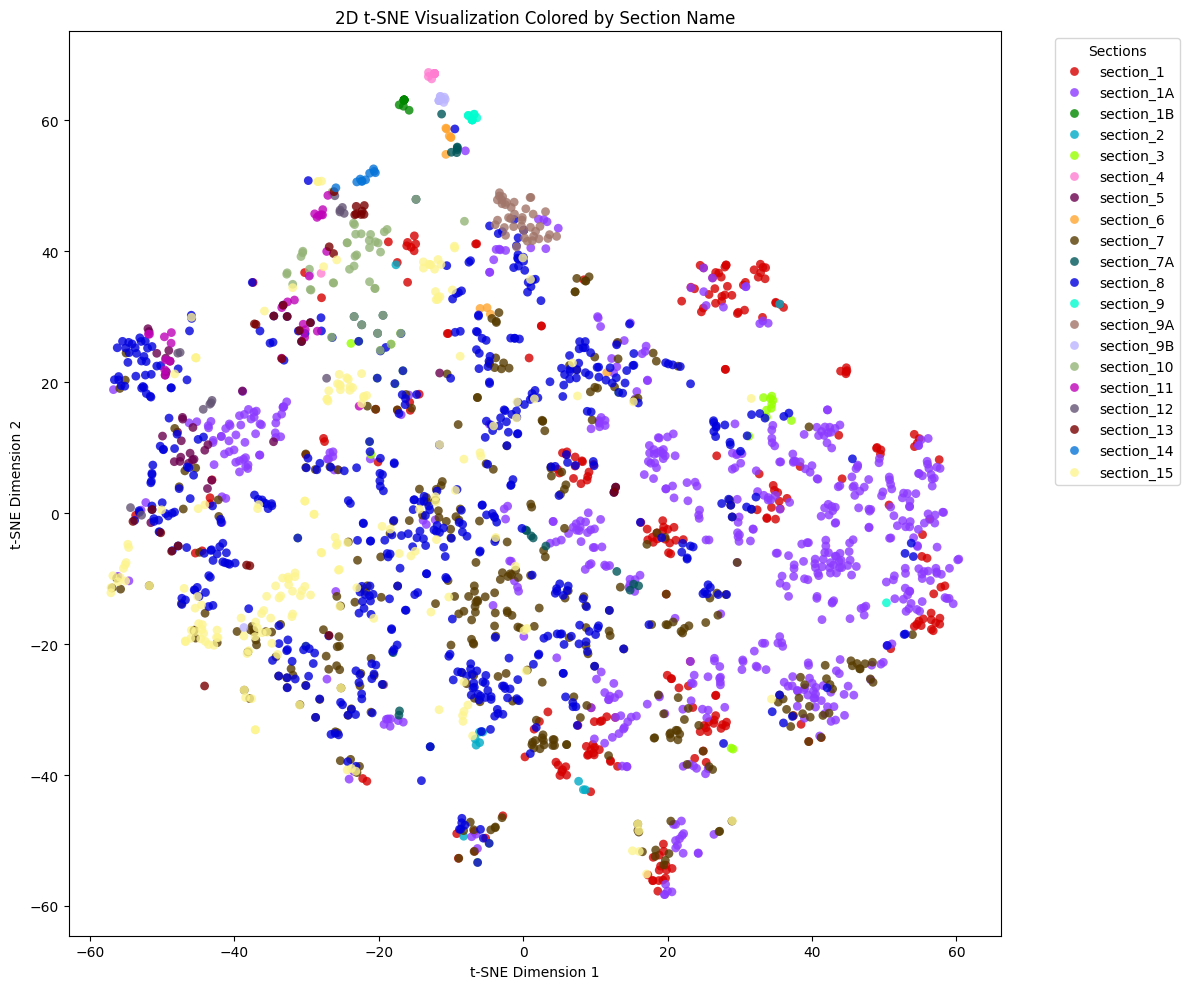

<Figure size 640x480 with 0 Axes>

In [248]:
plt.figure(figsize=(12,10))
base_colors = sns.color_palette("tab20", 20)
extra_colors = [(0.8, 0.2, 0.2), (0.2, 0.6, 0.8), (0.5, 0.5, 0.1)]  # Custom RGB tuples
palette_20 = cc.glasbey[:20]
sns.scatterplot(
    x='tsne_x', y='tsne_y', 
    hue='section_name', 
    palette=palette_20,
    data=df_chunked_pandas,
    s=40,
    alpha=0.8,
    edgecolor='none'
)

plt.title("2D t-SNE Visualization Colored by Section Name")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Sections', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.savefig("sections.jpeg", dpi=300, bbox_inches='tight')


### Summary Statistics

In [259]:
# Summary statistics table
summary_stats = pd.DataFrame({
   'Total Chunks': [len(df_chunked_pandas)],
   'Total Outliers': [df_chunked_pandas['outliers_kmeans'].sum()],
   'Outlier %': [df_chunked_pandas['outliers_kmeans'].mean() * 100],
   'Unique Companies': [df_chunked_pandas['cik'].nunique()],
   'Unique Sections': [df_chunked_pandas['section_name'].nunique()],
   'Avg Chunk Length': [df_chunked_pandas['chunk'].str.len().mean()],
   'K-means Clusters': [df_chunked_pandas['K_means_cluster'].nunique()],
})

# Outliers by company
outliers_by_company = df_chunked_pandas[df_chunked_pandas['outliers_kmeans']].groupby('cik').size()
outliers_by_company = outliers_by_company.sort_values(ascending=False)

# Outliers by section
outliers_by_section = df_chunked_pandas[df_chunked_pandas['outliers_kmeans']].groupby('section_name').size()
outliers_by_section = outliers_by_section.sort_values(ascending=False)

print("Summary Statistics:")
print(summary_stats.T)
print("\nTop 5 Companies with Most Outliers:")
print(outliers_by_company.head())
print("\nTop 5 Sections with Most Outliers:")
print(outliers_by_section.head())

# Save to CSV
summary_stats.to_csv("summary_statistics.csv", index=False)

Summary Statistics:
                            0
Total Chunks      2218.000000
Total Outliers      44.000000
Outlier %            1.983769
Unique Companies    10.000000
Unique Sections     20.000000
Avg Chunk Length  1505.046889
K-means Clusters    16.000000

Top 5 Companies with Most Outliers:
cik
1490873    11
1559720    10
1553404     5
1678463     5
718413      4
dtype: int64

Top 5 Sections with Most Outliers:
section_name
section_1     14
section_1A     8
section_1B     7
section_2      3
section_8      3
dtype: int64
